In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
import math

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import utilities.utility_functions as ut
import utilities.abundance_classes as ac
import utilities.chart_kwargs as ck

import utilities.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md

# data sources
data_sources = {    
    "survey_data":"results_with_zeroes.csv",
    "river_bassins":"river_basins.json",
    "beaches":"beaches_with_gis.csv",
    "codes":"mlw_codes.csv",
    "code_groups":"code_group2.json",
    "dims_data":"dims_data.csv"
}

# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-01-01'
end_date =today

# name of the output folder:
name_of_project = 'site_report_biel'

# set the maps
bassin_map = PILImage.open("resources/maps/aare_scaled.jpeg")
city_map = PILImage.open("resources/maps/biel_scaled.jpeg")

levels = {"city":"Biel/Bienne","water_name_slug":'bielersee', "river_bassin":'aare'}

level_names = [levels['city'], "Bielersee","Aare survey area"]

# variables for the directory tree
most_recent, survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# add the folder to the directory tree:
project_directory = ut.make_project_folder(output, name_of_project)

# keep track of output
files_generated = []
figure_num = 0
data_num = 0

# define the methods to handle the data .JSON or .csv:
my_data_methods = {'json':ut.json_file_get, 'csv':pd.read_csv}

# get your data:
survey_data, river_bassins, dfBeaches, dfCodes, code_groups, dfDims = sut.get_data_from_most_recent(data_sources, data_methods=my_data_methods)

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

def add_output(**kwargs):
    files_generated.append({'tag':kwargs['tag'], 'number':kwargs['figure_num'], 'file':kwargs['file'],'type':kwargs['a_type']})
    if kwargs['a_type'] == 'data':
        kwargs['data'].to_csv(F"{kwargs['file']}.csv", index=False)
    else:
        plt.savefig(F"{kwargs['file']}.jpeg", dpi=300)
def aggregate_a_group_of_codes(data, codes=[], groupby_column="", agg_columns={}):
    
    return data[data.code.isin(codes)].groupby(groupby_column, as_index=False).agg(agg_columns)

def replace_a_group_of_codes_with_one(data, new_code_values=[], codes_to_replace=[]):    
    
    som_data=data[~data.code.isin(codes_to_replace)].copy()
    new_data = pd.concat(new_code_values, ignore_index=True)
    return_data = pd.concat([som_data, new_data], ignore_index=True)
    
    return return_data

def agg_a_group_of_codes_with_one_code(data, new_values, a_list_loc_dates=[], a_model_code=" ", a_new_code=""):
    # aggregate and assign a new code for the values:
    new_df_rows = []
    new_vals = new_values.set_index('loc_date', drop=True)
    for adate in a_list_loc_dates:
        gx = data.loc[(data.loc_date == adate)&(data.code==a_model_code)].copy()        
        gx['code'] = a_new_code
        gx['quantity'] = new_vals.loc[[adate], 'quantity'][0]
        gx['pcs_m'] = new_vals.loc[[adate], 'pcs_m'][0]
        new_df_rows.append(gx)

    # create a data frame with the new values
    new_data = pd.concat(new_df_rows)
    
    return new_data, new_df_rows

def create_aggregate_groups(data, codes_to_agg=[], a_model_code="G79", a_new_code="Gfrags" ):
    
    agretd =  aggregate_a_group_of_codes(data, codes=codes_to_agg, groupby_column='loc_date', agg_columns={'quantity':'sum', 'pcs_m':'sum'})
    loc_dates = agretd.loc_date.unique()
    df, _ = agg_a_group_of_codes_with_one_code(data, agretd, a_list_loc_dates=loc_dates, a_model_code=a_model_code, a_new_code=a_new_code)    
    
    return df
# new column names for display
new_cols = {
    'total_time':'time to survey',
    'length':'meters surveyed',
    'area':'m² surveyed',
    'total_w':'total weight',
    'mac_plast_w':'plastic > 5mm weight',
    'mic_plas_w':'plastic < 5mm weight',
    'num_parts_staff':'staff',
    'num_parts_other':'help',
    'participants':'groups',
    'loc_date':'# samples'
}

# columns to aggregate dimensional data
agg_this = {
    'time to survey':'sum',
    'meters surveyed':'sum',
    'm² surveyed':'sum',
    'total weight':'sum',
    'plastic > 5mm weight':'sum',
    'plastic < 5mm weight':'sum',
    'staff':'sum',
    'help':'sum',
    '# samples':'nunique'
}

def make_a_summary_table(ax, data, cols_to_use, a_color='dodgerblue', font_size=12):
    
    
    ax.auto_set_font_size(False)
    the_cells = ax.get_celld()    
    
    banded_color = colors.to_rgba(a_color)
    banded_color= (*banded_color[:-1], 0.1)
    
    
    # the different areas of formatting
    top_row = [(0,i) for i,x in enumerate(cols_to_use)]
    bottom_row =[(len(data), i) for i,x in enumerate(cols_to_use) ]
    top_columns = top_row[1:]
    data_rows = [x for x in list(the_cells.keys()) if x not in top_row]
    odd_rows = [x for x in data_rows if x[0]%2 > 0]
    first_column = [x for x in data_rows if x[1] == 0]
    
    
    # make the first cell a littel smaller than the others
    ax[0,0].set_height(1/(len(data)))
    ax[0,0].set_text_props(**{'va':'top'})
   
    for a_cell in top_row:
        ax[a_cell].visible_edges = 'B'    
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        ax[a_cell].PAD = .1        
       
    for a_cell in top_columns:
        ax[a_cell].set_height((1.25/(len(data))))
        ax[a_cell].set_text_props(**{'va':'bottom'})
        ax[a_cell].set_edgecolor(banded_color)
        ax[a_cell].visible_edges = 'T'    
    
    for a_cell in odd_rows:
        ax[a_cell].set_facecolor( banded_color)
    
    for a_cell in data_rows:
        ax[a_cell].set_height(.75/(len(data)))
        ax[a_cell].visible_edges = 'BTLR' 
        ax[a_cell].set_text_props(**{'fontsize':font_size})
        ax[a_cell].set_edgecolor('white')
        
    for a_cell in first_column:
        ax[a_cell]._text.set_horizontalalignment('right')
        ax[a_cell].PAD = .02
        
    for a_cell in bottom_row:
        ax[a_cell].visible_edges = 'B'
        ax[a_cell].set_edgecolor(banded_color) 
        
        
    return ax

def add_a_new_code(a_name, a_model, a_dict_params, code_df):
    
    for param in a_dict_params:
        a_model[param] = a_dict_params[param]
    
    code_df.loc[a_name] = a_model
    
    return code_df
def shorten_the_value(an_array,a_df):
    a_df.loc[an_array[0], an_array[1]] = an_array[2]
    return a_df

# set the index of dfCodes to code:
dfCodes.set_index('code', inplace=True)

# Create new codes to aggregate the EPS pieces and the Plastic pieces
a_name = 'Gfrags'
a_model = dfCodes.loc['G79'].copy()
a_dict_params = {'description':'Fragmented plastics'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

a_name = 'Gfoam'
a_model = dfCodes.loc['G82'].copy()
a_dict_params = {'description':'Fragmented plastics'}

dfCodes = add_a_new_code(a_name, a_model, a_dict_params, dfCodes)

# these descriptions need to be shortened for display
dfCodes = shorten_the_value(["G74", "description", "Insulation: includes spray foams and foam board"], dfCodes)
dfCodes = shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = shorten_the_value(["G96", "description", "Sanitary-pads/panty liners/tampons"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code descriptions
code_material_map = dfCodes.material

<a id='top'></a>
## Identification, quantification and analysis of observable anthropogenic debris along swiss river and lakes (IQASL)

IQASL is a project sponosored by the Swiss Federal Office for the environment to quantify shoreline trash along swiss lakes and rivers in the Rhone, Aare, Ticino and Linth/Limmat catchment areas. This is accomplished by conducting multiple small scale and discrete **litter surveys** throughout the river bassin. The majority of samples are taken from lakes.

**What is a litter survey?**

A litter survey is the **identification and count of all objects found within a delimited area**, in this study all surveys were bordered on one side by water. Each object is placed into one of 260 categories¹. The location, date, survey dimensions and the total number of objects in each category is noted.

**Purpose of the surveys**

The survey results help ALL stakeholders identify the items that make up the mass of trash found in the natural environment on the shores of Swiss lakes and rivers. The surveys answer the following questions:

*  What items are found?
*  How much is found ? (total weights and item counts)
*  How often are these items found?
*  Where do you find the most?

These are the most frequently asked questions and should be considered when determining any mitigation or reduction strategies.

The project is based on the following assumptions:

*  The more trash there is on the ground the more a person is likely to find
*  The survey results represent the minimum amount of trash at that site²
*  For each survey: finding one item does not effect the chance of finding another³

**Purpose of this report**

Summarize the survey results for the municpality and define the magnitude of those results with respect to other locations in the river bassin and the aggregated national results.


**The survey results are presented as follows:**

* Total object count, total weight and weight of plastics
* The most abundant objects from the survey area and all the other survey areas sorted by total object count 
* Pieces of trash per meter (pcs/m): the ratio of number of objects found to the length of the shoreline
* Objects that were found in at least 60% of the surveys

**Contents of this report**

[Scope: description of the survey area](#surveyarea)
  * survey totals
  * survey locations
  * summary results
   
[Municipal results, survey dimensions, locations, aggregated totals](#surveytotals)
  * weights and measures: cumulative
  * number of objects removed
  * suvey location map
     
[Trash removed: most abundant objects](#abundance)
  * the most common objects from the municipality
  * the most common objects from the water feature or survey area
   
[Trash removed: the most often and abundant](#frequence)
  * objects that are found in more than 50% of surveys
  * objects that are the most abundant
  * objects found in less than 50% of the surveys
   
[Trash removed: utility and material](#matutility)
  * utility classification
  * material classification

[Annex](#annex)
  * effective data: report of missing records
  * survey location coordinates
  * population profile and results by municipality
  * itemized list of objects removed


**More information**

For more information about the project visit [project home](https://www.plagespropres.ch/).

If you would like more information specific information about this survey area please contact:

1. Swiss federal office for the environment - Municipal waste section
2. analyst@hammerdirt.ch

¹ [The EU guide on monitoring marine litter](https://mcc.jrc.ec.europa.eu/documents/201702074014.pdf)<br> ² There is most likely more trash at the survey site, but certainly not less than what was recorded.<br>³ Independent observations : [stats stackexchange](https://stats.stackexchange.com/questions/116355/what-does-independent-observations-mean)

In [2]:
# format the date to timestamp and slice the data by start/end date
dfSurveys = sut.fo_rmat_and_slice_date(survey_data.copy(), a_format="%Y-%m-%d", start_date=start_date, end_date=end_date)

# add the grouping column defined by river_bassins
data = sut.add_a_grouping_column(dfSurveys, river_bassins, column_to_match="water_name_slug")

# put the data into a class
# kwargs for the abundance class
a_class_kwargs = dict(
    code_group_data=code_groups,
    levels=['river_bassin', 'water_name_slug', 'city'],
    river_bassins=river_bassins,
    exp_variables=['population','buildings', 'streets', 'intersects'],       
    code_group_loc=output,    
)

# the data labled by river bassin, water feature, city and beach name with independent variables attached
a = sut.SurveyData(data,  dfBeaches, these_cols=['loc_date', 'location', 'water_name_slug','date'], **a_class_kwargs)

# define the final data set here:
a_data = a.survey_data.copy()

# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83']

# the codes for the fragmented plastics
some_frag_plas = list(a_data[a_data.groupname == 'plastic pieces'].code.unique())
    
the_plast_rows = create_aggregate_groups(a_data, codes_to_agg=some_frag_plas,a_model_code="G79", a_new_code="Gfrags")
the_foam_rows = create_aggregate_groups(a_data, codes_to_agg=some_foams, a_model_code="G82", a_new_code="Gfoam")

# the foam codes and fragmented plastic codes have been aggregated in to Gfrags and Gfoam
new_som_data = replace_a_group_of_codes_with_one(a_data, new_code_values=[the_plast_rows, the_foam_rows], codes_to_replace=[*some_frag_plas, *some_foams])

# keep the orginal data to test on
before_agg = a_data.copy()

# replace a_data with new new_som_data
a_data = new_som_data.copy()

# identify all records with a quantity > 0
a_data['fail'] = a_data.quantity > 0

# map material to a_data
a_data['material'] = a_data.code.map(lambda x: code_material_map[x])
material_totals = a_data.groupby('material').quantity.sum()

# get group totals:
group_totals = a_data[a_data.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
group_totals_all = group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

# get top ten
a_t_ten = a.code_totals.sort_values(ascending=False)

# number of samples
a_n_samps = len(a.daily_totals_all)

# thats it! all the survey records with the independent variables attached and columns to group by
# date, location, (location, date), river bassin, water body, city, material, usage group, or object

# define the data set for this example:
trb = a_data.loc[a_data.river_bassin == levels['river_bassin']].copy()

# get the fail rates for the river bassin
fail_rates_trb = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

# survey_totals river bassin
dts=trb.groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()

# code totals for the river bassin
rb_code_t= trb.groupby('code', as_index=False).quantity.sum()

# percent of total
rb_code_t["% of total"] = rb_code_t.quantity/rb_code_t.quantity.sum()
rb_code_t.set_index('code', inplace=True)

# river bassin top ten
rb_t_ten = rb_code_t['quantity'].sort_values(ascending=False)

# get groupname totals
trb_group_totals = trb[trb.quantity > 0].groupby(['loc_date','groupname'], as_index=False).agg({'pcs_m':'sum', 'quantity':'sum'})
trb_group_totals = trb_group_totals.groupby(['groupname']).agg({'pcs_m':'median', 'quantity':'sum'})

rb_n_samps = len(trb.loc_date.unique())
rb_num_obj = trb.quantity.sum()
rb_num_locs = len(trb.location.unique())
rb_locs = trb.location.unique()

# rb dimensional data
rb_dims = dfDims[dfDims.location.isin(trb.location.unique())]
rb_dims_sum = rb_dims.agg({'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
rb_dims_sum['pcs/m - median'] = dts.pcs_m.median()
rb_dims_sum['# objects'] = trb.quantity.sum()
rb_dims_sum['# locations'] = trb.location.nunique()
rb_dims_sum['# samples '] = len(trb.loc_date.unique())

rb_dims_sum.rename({'length':'meters surveyed', 'area':'m² surveyed', 'time_minutes':'# hours', 'total_w':'# kilos total', 'mac_plast_w':'# kilos plastic'}, inplace=True)
rb_dims_sum['# hours'] = rb_dims_sum['# hours']/60
rb_dims_sum[ '# kilos plastic'] = rb_dims_sum[ '# kilos plastic']/1000

# the water body
f_data = trb[trb.water_name_slug == levels['water_name_slug']].copy()
f_n_samps = len(f_data.loc_date.unique())

# code totals for the river bassin
f_code_t= f_data.groupby('code', as_index=False).quantity.sum()

# percent of total
f_code_t["% of total"] = f_code_t.quantity/f_code_t.quantity.sum()
f_code_t.set_index('code', inplace=True)

# river bassin top ten
f_t_ten = f_code_t['quantity'].sort_values(ascending=False)

# the city that we are looking at:
biel = trb[trb.city == levels['city']].copy()
c_beaches = biel.location.unique()

# all the survey locations in the city
city_beaches = dfBeaches.loc[dfBeaches.index.isin(c_beaches)][['location','latitude','longitude', 'water_name', 'bfsnum']]
city_beaches.rename(columns={'water_name':'lake/river'}, inplace=True)
city_beaches = city_beaches.set_index('location', drop=True)

# the top ten codes by quantity
city_code_t  = biel.groupby('code', as_index=False).quantity.sum()
city_code_t["% of total"] = city_code_t.quantity/city_code_t.quantity.sum()
city_code_t.set_index('code', inplace=True)
city_t_ten = city_code_t['quantity'].sort_values(ascending=False)

# survey totals city
the_city = trb[trb.city == levels['city']].groupby(['loc_date', 'date'], as_index=False).pcs_m.sum()
survey_totals_median = the_city.pcs_m.median()
c_n_samps = len(biel.loc_date.unique())

# end of report print out of total inventory
biel['item'] = biel.code.map(lambda x: code_description_map[x])
complete_inventory = biel.loc[biel.quantity > 0].groupby(['item','code','material','groupname'], as_index=True).agg({'quantity':'sum', 'pcs_m':'median'})

# dimensional data
biel_dims = dfDims[dfDims.location.isin(biel.location.unique())]
biel_dims_sum = biel_dims.agg({'loc_date':'nunique', 'length':'sum', 'area':'sum', 'time_minutes':'sum', 'total_w':'sum','mac_plast_w':'sum'})
biel_dims_sum['pcs_m'] = survey_totals_median
biel_dims_sum['quantity'] = biel.quantity.sum()
biel_dims_sum['locations'] = biel.location.nunique()

# locations at biel
biel_loc = biel.location.unique()

# fail rate
biel_fail = biel.loc[biel.quantity > 0]
biel_nfail = len(biel_fail.code.unique())

In [3]:
md(F"<a id='surveyarea'></a>[top](#top)\n\n### Municipal survey results: {levels['city']}")

<a id='surveyarea'></a>[top](#top)

### Municipal survey results: Biel/Bienne

In [4]:
md(F"#### The {level_names[2]}")

#### The Aare survey area


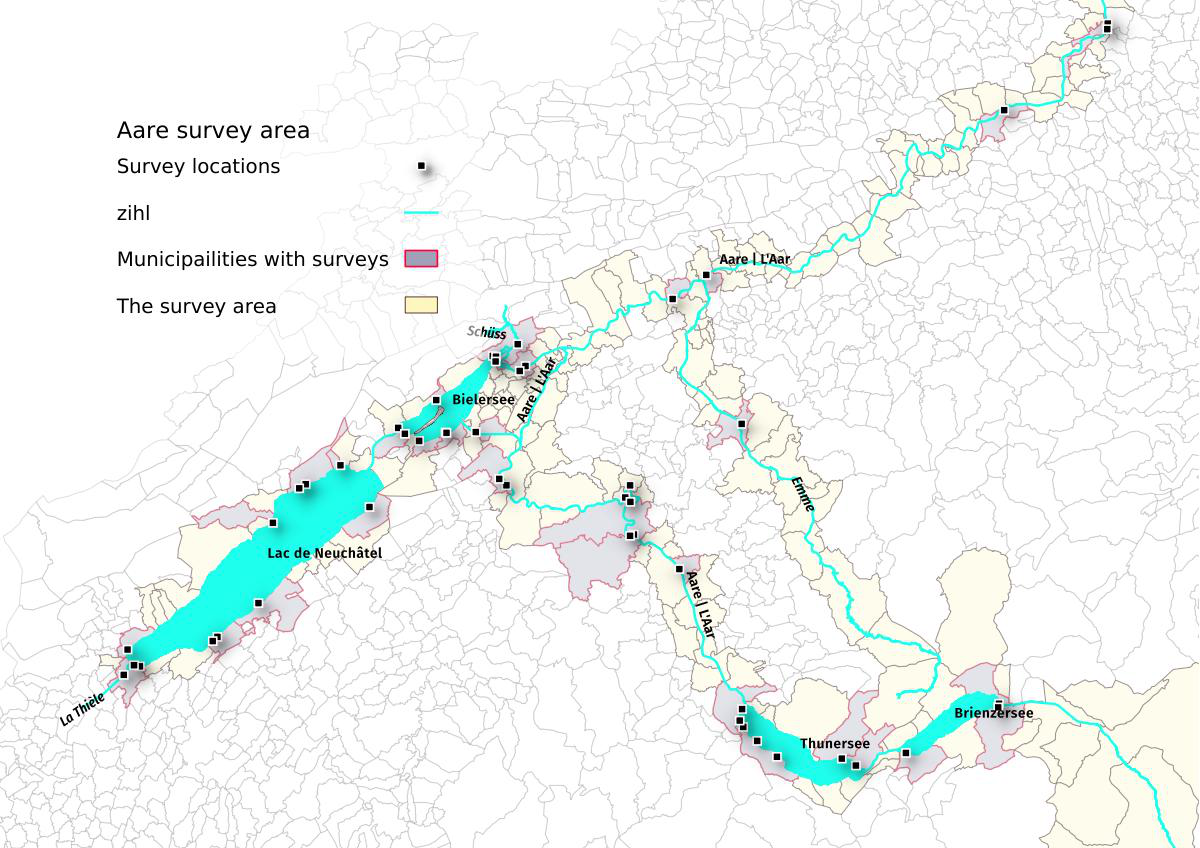

In [5]:
output = io.BytesIO()
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

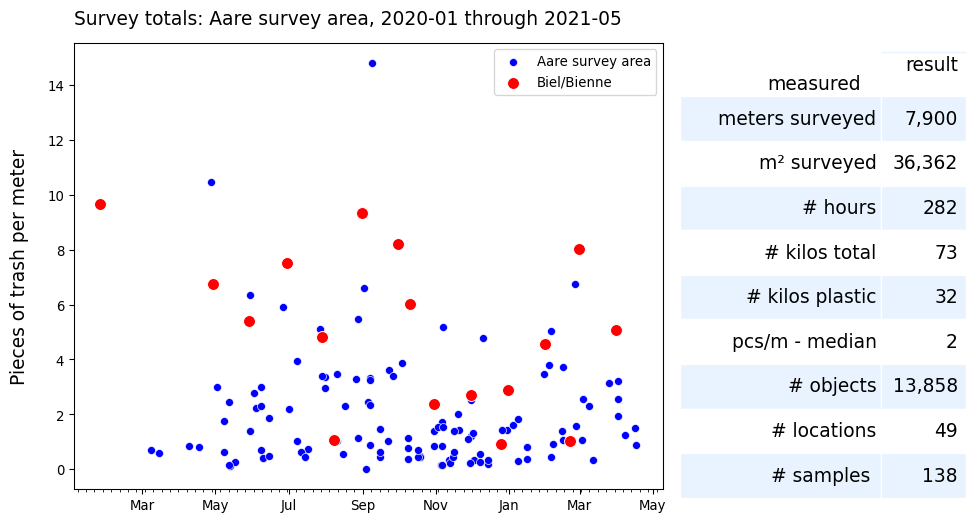

In [23]:
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

table_vals = [math.ceil(x) for x in rb_dims_sum.values]
table_str_vals = ['{:,}'.format(x) for x in table_vals]

table_data = list(zip(rb_dims_sum.index,table_str_vals ))
table_data = [('measured', 'result'), *table_data]

fig = plt.figure(figsize=(12,6), dpi=96)
gs = GridSpec(1, 12, figure=fig, wspace=.3, hspace=.3, top=.9)

axone = fig.add_subplot(gs[:, :8])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 8:])
# axone=axs[0]
# axtwo=axs[1]

sns.scatterplot(data=dts, x='date', y='pcs_m', color='b', label=F"{level_names[2]}", ax=axone)
sns.scatterplot(data=the_city, x='date', y='pcs_m', color='r', s=80, label=levels['city'], ax=axone)

axone.set_xlabel("")
axone.set_ylabel("Pieces of trash per meter", **ck.xlab_k14)
axone.set_title(F"Survey totals: {level_names[2]}, {start_date[:7]} through {end_date[:7]}",  **ck.title_k14)
axone.xaxis.set_minor_locator(days)
axone.xaxis.set_major_formatter(months_fmt)

a_table = axtwo.table(table_data, loc='upper center', fontsize=14, colWidths=[.70,.30])

a_table = make_a_summary_table(a_table,('measured', 'result'),('measured', 'result'))

a_table.set_fontsize(14)

table_rows = a_table.get_celld()
cellDict = a_table.get_celld()

for i in range(0,2):
    cellDict[(0,i)].set_height(.1)
    for j in range(1,len(table_data)):
        cellDict[(j,i)].set_height(.1)

axtwo.grid(False)
axtwo.axis('off')

plt.show()
plt.close()

In [7]:
section_header = F"<a id='surveytotals'></a>[top](#top)\n\n### Aggregated results: {levels['city']}"
md(section_header)

<a id='surveytotals'></a>[top](#top)

### Aggregated results: Biel/Bienne

In [8]:
summary = F"""1. Number of surveys: {int(biel_dims_sum['loc_date'])}\n
2. Number of locations surveyed: {int(biel_dims_sum['locations'])}\n 
3. Total meters of shoreline surveyed: {int(biel_dims_sum['length'])}
4. Total surface area: {int(biel_dims_sum['area'])}m²
5. Total time in hours: {int(biel_dims_sum['time_minutes']/60)}
6. Pieces of trash per meter of shoreline: {round(biel_dims_sum['pcs_m'],2)}
7. Number of objects removed: {int(biel_dims_sum['quantity'])}
8. Kilograms removed : {round(biel_dims_sum['total_w'], 2)}
9. Kilograms of plastic removed: {round((biel_dims_sum['mac_plast_w']/1000), 2)}
"""
md(summary)

1. Number of surveys: 17

2. Number of locations surveyed: 3
 
3. Total meters of shoreline surveyed: 697
4. Total surface area: 5092m²
5. Total time in hours: 47
6. Pieces of trash per meter of shoreline: 5.06
7. Number of objects removed: 3309
8. Kilograms removed : 8.2
9. Kilograms of plastic removed: 4.0


In [9]:
section_header = F"#### <span style='color:#008891'>Survey locations {levels['city']}</span>"
md(section_header)

#### <span style='color:#008891'>Survey locations Biel/Bienne</span>


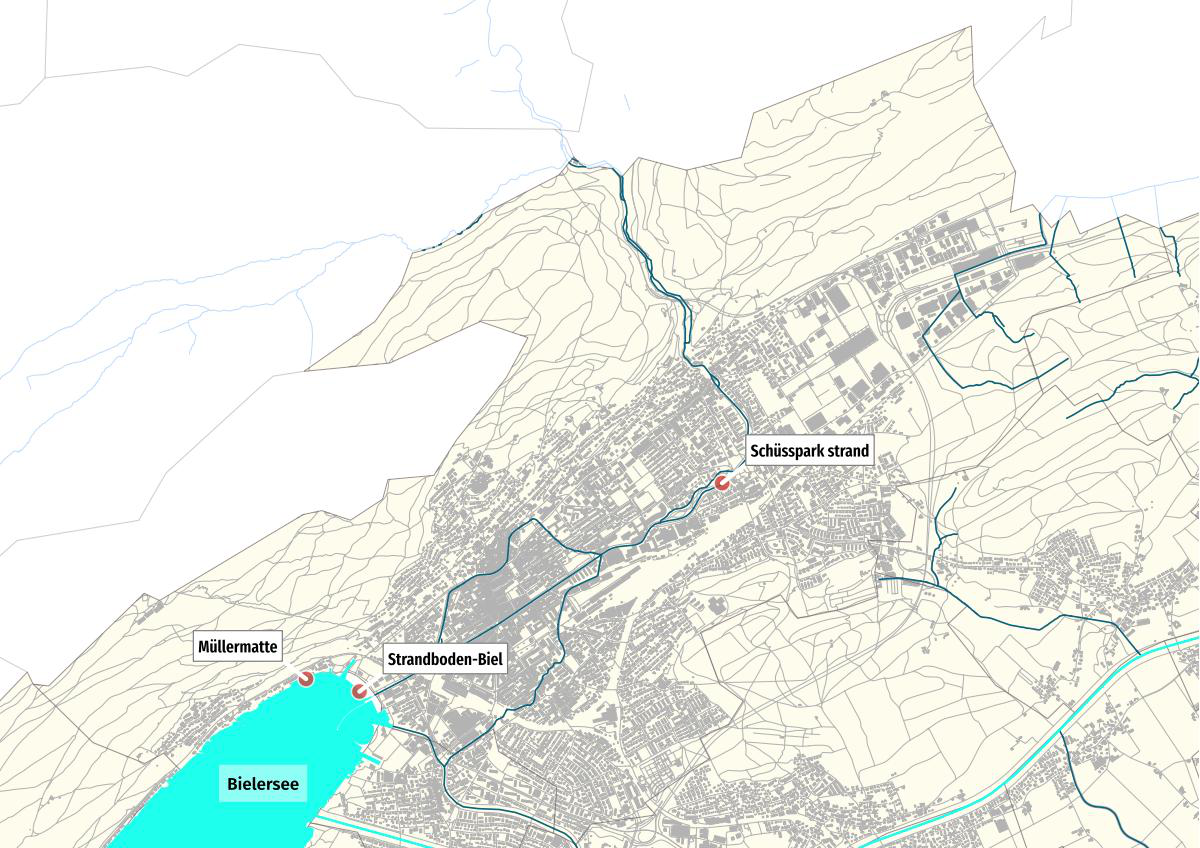

In [10]:
output = io.BytesIO()
city_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
IPython.display.HTML(html)

[top](#top)
<a id="abundance"></a>
### The 10 most abundant objects

In [11]:
add_feature_top_ten = f_n_samps > 1

astring = "The survey results vary from region to region. If your municipality shows higher results for a particular object or group you may be close to the source or a zone of accumulation."

if add_feature_top_ten:
    an_alert = F"The top ten items from {levels['city']} and {level_names[1]}.\n {astring}"
else:
    an_alert = F"The top ten items from {levels['city']} and the {level_names[2]} bassin.\n {astring}"
md(an_alert)

The top ten items from Biel/Bienne and Bielersee.
 The survey results vary from region to region. If your municipality shows higher results for a particular object or group you may be close to the source or a zone of accumulation.

In [12]:
# get the top ten at each aggregation level
the_top_ten_combined = set([*city_t_ten.index[:10], *f_t_ten.index[:10], *rb_t_ten.index[:10], *a_t_ten.index[:10]])

#kwargs for aggregator
these_kwargs = dict(
    group='code',
    dailycols={'pcs_m':'sum', 'quantity':'sum'}, 
    agg_cols={"pcs_m":"mean"},
    national=True,
    col_name="All river bassins",
    level_names=level_names,
    bassin_summary=False,
    daily=True)
    
# the top ten from the city 
t_ten_city = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(city_t_ten.index[:10] ))], levels, **these_kwargs)

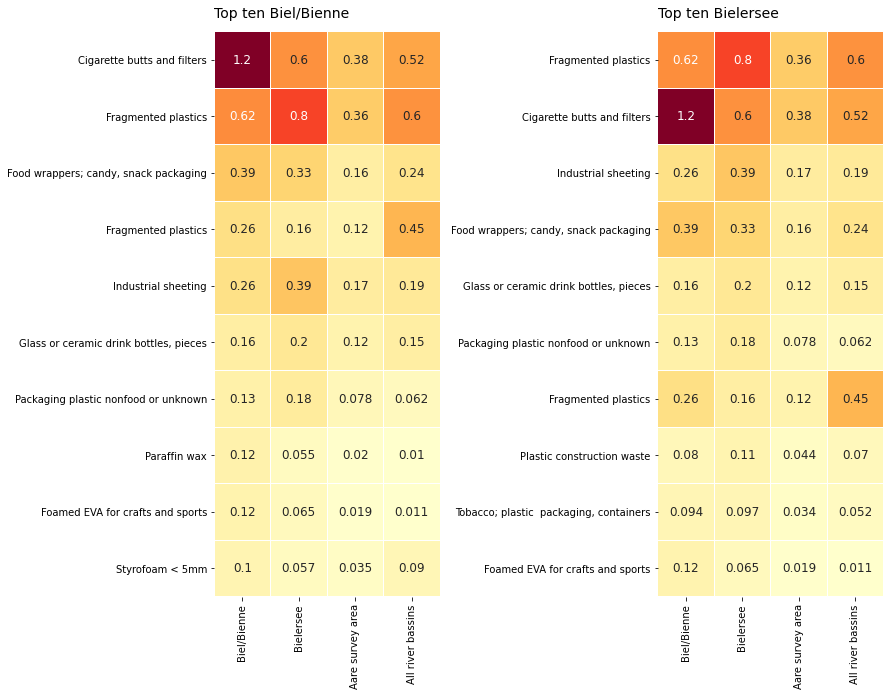

In [13]:
# reindex to description
t_ten_city['item'] = t_ten_city.index.map(lambda x: code_description_map[x])
code_t_ten = t_ten_city.set_index('item', drop=True)
code_t_ten.sort_values(by=levels['city'], ascending=False, inplace=True)
# code_t_ten.rename(columns=level_names, inplace=True)

# compare to either the closest water feature or the river bassin
if add_feature_top_ten:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(f_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
   
    second_chart.sort_values(by=level_names[1], ascending=False, inplace=True)
#     second_chart.rename(columns=level_names, inplace=True)
    second_chart_title = level_names[1]
else:
    second_chart = ac.agg_pcs_m_by_city_feature_basin_all(a_data[(a_data.code.isin(rb_t_ten.index[:10]))], levels, **these_kwargs)
    second_chart['item'] = second_chart.index.map(lambda x: code_description_map[x])
    second_chart = second_chart.set_index('item', drop=True)
    
    second_chart.sort_values(by=level_names[2], ascending=False, inplace=True)
  
    second_chart_title = F"{level_names[2]}"


# chart that
fig = plt.figure(figsize=(12,14))
gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])

axone = fig.add_subplot(gs[:, 0])
# axone = axs[0]
axtwo = fig.add_subplot(gs[:, 2])

sns.heatmap(code_t_ten, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.1, linecolor='white')
axone.set_title(F"Top ten {levels['city']}", **ck.title_k14)
# axone.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axone.tick_params(**ck.xlabels_top, **ck.no_xticks)
axone.set_ylabel("")

sns.heatmap(second_chart, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.2',  square=True, cbar=False, linewidth=.1, linecolor='white')
axtwo.set_title(F"Top ten {second_chart_title}", **ck.title_k14)
# axtwo.set_xlabel("Combined top ten pcs/m", **ck.label_r14)
# axtwo.tick_params(**ck.xlabels_top, **ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axone.get_xticklabels(), rotation=90)
plt.setp(axtwo.get_xticklabels(), rotation=90)

plt.show()
plt.close()

[top](#top)<a id="frequence"></a>
### How often are these objects found?

In [14]:
add_feature_top_ten = f_n_samps > 1
city_fail_rate = c_n_samps > 1



astring = "Some objects are found often and in elevated quantities, others are found often and in small quantities and some times objects are found less often but in large quantities. Knowing the diffference can help find the sources."

if add_feature_top_ten:
    first_level = levels['city']
    second_level = levels['water_name_slug']
    fail_codes=list(set([*city_t_ten.index[:10],*f_t_ten.index[:10]]))
    
else:
    first_level = levels['city']
    second_level = levels['river_bassin']
    fail_codes=list(set([*city_t_ten.index[:10],*rb_t_ten.index[:10]]))
    
an_alert = F"Frequency of occurence from {first_level} and the {level_names[2]}.\n {astring}"
md(an_alert)

Frequency of occurence from Biel/Bienne and the Aare survey area.
 Some objects are found often and in elevated quantities, others are found often and in small quantities and some times objects are found less often but in large quantities. Knowing the diffference can help find the sources.

In [15]:
# this is a convenience function for the abundance class
# the fail rate needs to be recalculated at each aggregation level
fail_rates_df = ac.agg_fail_rate_by_city_feature_basin_all(a_data, levels, group='code')

a_fail_rate = 60

d = fail_rates_df[(fail_rates_df.iloc[:, :] > (a_fail_rate/100)).any(axis=1)]

# top ten from both levels and > 50% fail raite
frst_level_fail = d.loc[d.index.isin(fail_codes)][first_level].sort_values(ascending=False)[:10].index


objs_both = frst_level_fail
objs_fail_not_t_ten = list(set(fail_codes)-set(frst_level_fail))
objs_not = [x for x in d.index if x not in fail_codes]

In [16]:
pcs_d_both = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_both))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_both])]
found_fail = ' '.join(found_fail )
md(F"""**Objects found in at least {a_fail_rate}% of surveys AND in the top ten**<br>
Combined they had an average pieces per meter per survey of {round(pcs_d_both['mean'], 2)}, a min of {round(pcs_d_both['min'], 2)} and max of {round(pcs_d_both['max'], 2)}<br>
{found_fail}\n
""")

**Objects found in at least 60% of surveys AND in the top ten**<br>
Combined they had an average pieces per meter per survey of 3.32, a min of 0.37 and max of 6.76<br>
<br/>1. Fragmented plastics <br/>2. Cigarette butts and filters <br/>3. Food wrappers; candy, snack packaging <br/>4. Fragmented plastics <br/>5. Industrial sheeting <br/>6. Tobacco; plastic  packaging, containers <br/>7. Plastic construction waste <br/>8. Glass or ceramic drink bottles, pieces <br/>9. Packaging plastic nonfood or unknown <br/>10. Styrofoam < 5mm



In [17]:
if len(objs_fail_not_t_ten) > 0:
    pcs_d_fail = a_data[(a_data.quantity > 0)&(a_data.code.isin(objs_fail_not_t_ten))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    not_found_fail = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_fail_not_t_ten])]
    not_found_fail = ' '.join(not_found_fail)
    a_string = F"""**Objects found in less than {a_fail_rate}% of the surveys and in the top ten**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_fail['mean'], 2)}, a min of {round(pcs_d_fail['min'], 2)} and max of {round(pcs_d_fail['max'], 2)}
    <br>{not_found_fail}\n
    """   
else:
    a_string="\n"

md(a_string)

**Objects found in less than 60% of the surveys and in the top ten**<br>Combined they had an average pieces per meter per survey of 0.11, a min of 0.01 and max of 0.86
    <br><br/>1. Foamed EVA for crafts and sports <br/>2. Paraffin wax

    

In [18]:
if len(objs_not) > 0:
    pcs_d_pcs = a_data[(a_data.quantity > 0)&(a_data.city == levels['city'])&(a_data.code.isin(objs_not))].groupby('loc_date').pcs_m.sum().agg(['mean', 'min', 'max'])
    fail_not_found = [F"<br/>{str((i+1))}. {x}" for i,x in enumerate([code_description_map[x] for x in objs_not])]
    fail_not_found = ' '.join(fail_not_found )
    astring = F"""**Objects found in at least {a_fail_rate}% of the surveys AND NOT in the top ten**<br>Combined they had an average pieces per meter per survey of {round(pcs_d_pcs['mean'], 2)}, a min of {round(pcs_d_pcs['min'], 2)} and max of {round(pcs_d_pcs['max'], 2)}
    <br>{fail_not_found}\n    
    """
else:
    astring = ""

md(astring)

**Objects found in at least 60% of the surveys AND NOT in the top ten**<br>Combined they had an average pieces per meter per survey of 0.66, a min of 0.04 and max of 1.38
    <br><br/>1. Food containers single use foamed or plastic <br/>2. Plastic fragments angular <5mm <br/>3. Industrial pellets (nurdles) <br/>4. Foil wrappers, aluminum foil <br/>5. Metal bottle caps, lids & pull tabs from cans <br/>6. Other medical items (swabs, bandaging, adhesive plaster) <br/>7. Lid/cap rings from plastic bottles/containers <br/>8. Lollypop sticks <br/>9. Straws and stirrers <br/>10. String < 1cm <br/>11. Insulation: includes spray foams and foam board <br/>12. Fireworks; rocket caps, exploded parts & packaging <br/>13. Cotton bud/swab sticks
    
    

[top](#top)
<a id='matutility'></a><a id='scope'></a>
### Material type and Utility: percent of total objects collected

**Material type** The material type is determined based on the classification in the the guide on monitoring marine litter. 

**Utility:** The utility type is based on the utilisation of the object prior to it being discarded. Objects are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

For example, a piece of plastic would be placed into the category 'Fragmented plastics', depending on its size. However, a piece of plastic that was once a bucket
and we know this because we are familiar with either the brand or the product, is placed in a code for buckets⁸.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes plastic sheeting, mulch films 
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

<span style="font-size:10">⁸ See the annex for the complete list of objects identified, includes category and group classification</span>

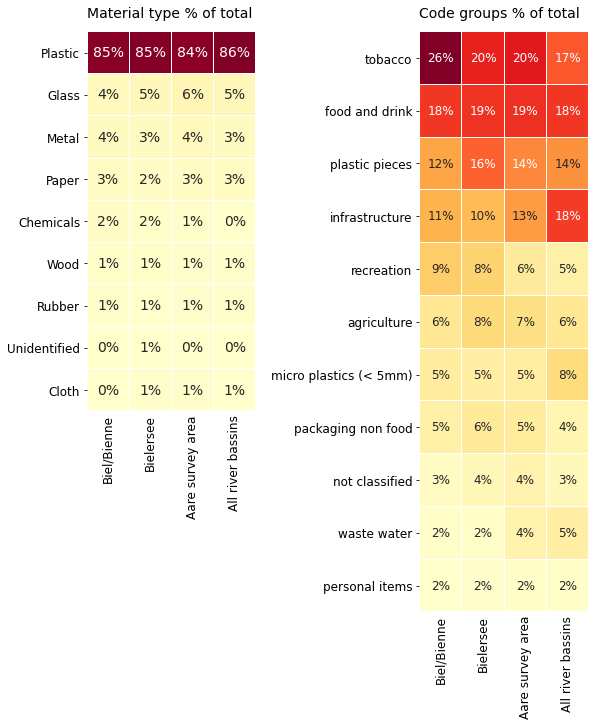

In [19]:
column_denominators = [
    biel.quantity.sum(),
    trb[trb.water_name_slug == levels['water_name_slug']].quantity.sum(),
    trb.quantity.sum(),
    a_data.quantity.sum()
]

code_group_kwargs = dict(
    group='groupname',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    bassin_summary=False,
    level_names=level_names
)

code_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels,**code_group_kwargs)
code_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)
  
cgroup_p_t = code_groups_pcs_m.divide(column_denominators).round(3)

material_group_kwargs = dict(
    group='material',
    dailycols={'pcs_m':'sum', 'quantity':'sum'},
    agg_cols={'quantity':'sum'},
    national=True,
    col_name="All river bassins",
    daily=False,
    bassin_summary=False,
    level_names=level_names
)

material_groups_pcs_m = ac.agg_pcs_m_by_city_feature_basin_all(a_data, levels, **material_group_kwargs)
material_groups_pcs_m.sort_values(by=levels['city'], ascending=False, inplace=True)

mat_g_h = material_groups_pcs_m.divide(column_denominators).round(3)


fig = plt.figure(figsize=(9,14))

gs = GridSpec(12, 3, figure=fig, wspace=.5, hspace=.5, top=.9, width_ratios=[.45,.1,.45])


axone = fig.add_subplot(gs[0:6, 0])
sns.heatmap(mat_g_h, ax=axone, cmap='YlOrRd', annot=True, annot_kws={"fontsize":14}, fmt='.0%', cbar=False, square=True, linewidth=.1, linecolor='white')
axone.set_title("Material type % of total", **ck.title_k14)
axone.tick_params(**ck.no_xticks)
axone.set_ylabel("")

axtwo = fig.add_subplot(gs[0:9, 2])
sns.heatmap(cgroup_p_t, ax=axtwo, cmap='YlOrRd', annot=True, annot_kws={"fontsize":12}, fmt='.0%',   cbar=False, linewidth=.1, linecolor='white')

axtwo.set_title("Code groups % of total", **ck.title_k14)
axtwo.tick_params(**ck.no_xticks)
axtwo.set_ylabel("")

plt.setp(axtwo.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axtwo.get_yticklabels(), rotation=0, fontsize=12)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=12)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=12)
plt.show()

### <span style="color:#008891">More information</span>

Contact hammerdirt.ch for any questions about the content of this report. If you would like a report for your municipality contact the Swiss federal office for the environment: Municipal waste section.

In [20]:
author = "roger@hammerdirt.ch"
my_message = "Statistics is fun when you do it outside"
md(F"""### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*{author}* pushed the run button on {today}.
""")

### <span style="color:#000099">Have a great day</span>
**This project was made possible by the Swiss federal office for the environment.**<br>
This document originates from https://github.com/hammerdirt-analyst/iqals all copyrights apply.<br>
*roger@hammerdirt.ch* pushed the run button on 2021-05-19.


[top](#top)
<a id=annex></a>
### <span style="color:#008891">Annex</span>

#### Survey locations

In [21]:
city_beaches

,latitude,longitude,lake/river,bfsnum
location,,,,
Müllermatte,47.133339,7.227907,Bielersee,371
Schüsspark strand,47.146500,7.268620,Schüss,371
Strandboden-Biel,47.132510,7.233142,Bielersee,371


#### Inventory of all items removed

In [22]:
pd.set_option('display.max_rows', None)
complete_inventory.sort_values(by='quantity', ascending=False)

,,,,quantity,pcs_m
item,code,material,groupname,,
Cigarette butts and filters,G27,Plastic,tobacco,781,1.150
Fragmented plastics,Gfrags,Plastic,plastic pieces,403,0.500
"Food wrappers; candy, snack packaging",G30,Plastic,food and drink,253,0.415
Industrial sheeting,G67,Plastic,agriculture,166,0.255
Fragmented plastics,Gfoam,Plastic,infrastructure,163,0.200
Packaging plastic nonfood or unknown,G941,Plastic,packaging non food,95,0.140
"Glass or ceramic drink bottles, pieces",G200,Glass,food and drink,94,0.080
Foamed EVA for crafts and sports,G940,Plastic,recreation,84,0.090
Paraffin wax,G213,Chemicals,recreation,75,0.145
